In [1]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

import warnings
import seaborn as sns 
from itertools import cycle
import matplotlib.pyplot as plt

%matplotlib inline 
plt.style.use('bmh')
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
warnings.filterwarnings("ignore")
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
data = pd.read_csv('SoleaTimeSeriesDataset-Temperature-Salinity.csv', usecols=['id','year_month','obs_id','salinitySurface','temperatureSurface'])
data['year_month'] = pd.to_datetime(data['year_month'])
data['year'] = data['year_month'].dt.year
data['month'] = data['year_month'].dt.month
data = data.set_index('year_month')
data.tail()

,id,obs_id,temperatureSurface,salinitySurface,year,month
year_month,,,,,,
2017-08-01,16292017-08,1629,23.582354,36.182110,2017,8
2017-09-01,16292017-09,1629,21.929382,36.138615,2017,9
2017-10-01,16292017-10,1629,19.932003,36.038403,2017,10
2017-11-01,16292017-11,1629,17.789633,36.132930,2017,11
2017-12-01,16292017-12,1629,15.722528,36.223846,2017,12


In [3]:
#dataTemp = data[data['obs_id']==2][['temperatureSurface']]
#dataTemp.index.freq = 'MS'

dataSal = data[data['obs_id']==2][['salinitySurface']]
dataSal.index.freq = 'MS'
dataSal.head()

,salinitySurface
year_month,
2008-01-01,38.059185
2008-02-01,37.981125
2008-03-01,38.007427
2008-04-01,37.915913
2008-05-01,37.992910


In [4]:
train_data = dataSal.iloc[:96]
test_data = dataSal.iloc[96:]

### Fitting the Model

In [5]:
span = 12
alpha = 2/(span+1)
simpleExpSmooth_model = SimpleExpSmoothing(train_data['salinitySurface']).fit(smoothing_level=alpha,optimized=False)
doubleExpSmooth_model = ExponentialSmoothing(train_data['salinitySurface'],trend='add',seasonal_periods=12).fit()
tripleExpSmooth_model = ExponentialSmoothing(train_data['salinitySurface'],trend='add',seasonal='add',seasonal_periods=12).fit()

### Evaluating Model

In [6]:
predictions_simpleExpSmooth_model = simpleExpSmooth_model.forecast(24)
predictions_doubleExpSmooth_model = doubleExpSmooth_model.forecast(24)
predictions_tripleExpSmooth_model = tripleExpSmooth_model.forecast(24)

In [7]:
predictions_tripleExpSmooth_model

2016-01-01    38.259251
2016-02-01    38.182110
2016-03-01    38.119566
2016-04-01    38.048063
2016-05-01    38.042674
2016-06-01    37.985813
2016-07-01    38.001286
2016-08-01    38.092952
2016-09-01    38.326262
2016-10-01    38.431674
2016-11-01    38.337741
2016-12-01    38.305122
2017-01-01    38.284101
2017-02-01    38.206960
2017-03-01    38.144416
2017-04-01    38.072913
2017-05-01    38.067524
2017-06-01    38.010663
2017-07-01    38.026136
2017-08-01    38.117802
2017-09-01    38.351112
2017-10-01    38.456524
2017-11-01    38.362591
2017-12-01    38.329972
Freq: MS, dtype: float64

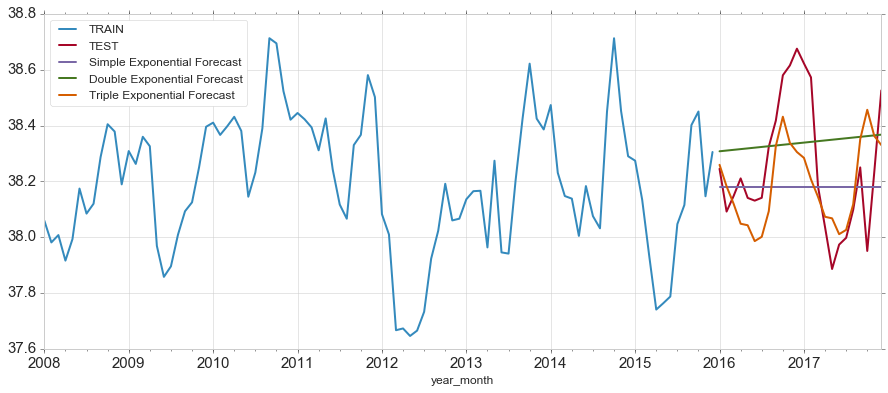

In [8]:
train_data['salinitySurface'].plot(legend=True,label='TRAIN')
test_data['salinitySurface'].plot(legend=True,label='TEST',figsize=(15,6))
predictions_simpleExpSmooth_model.plot(legend=True,label='Simple Exponential Forecast')
predictions_doubleExpSmooth_model.plot(legend=True,label='Double Exponential Forecast')
predictions_tripleExpSmooth_model.plot(legend=True,label='Triple Exponential Forecast');

### Evaluation

In [9]:
print('Simple Exponential Smoothing RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(test_data,predictions_simpleExpSmooth_model))))
print('Double Exponential Smoothing RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(test_data,predictions_doubleExpSmooth_model))))
print('Triple Exponential Smoothing RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(test_data,predictions_tripleExpSmooth_model))))

Simple Exponential Smoothing RMSE: 0.2423
Double Exponential Smoothing RMSE: 0.2491
Triple Exponential Smoothing RMSE: 0.2033


In [10]:
test_data.std()

salinitySurface    0.236641
dtype: float64

Having RMSE less than std is a good indicator for our forecasting model

## Refit model on the entire data set and forecast future unknown data

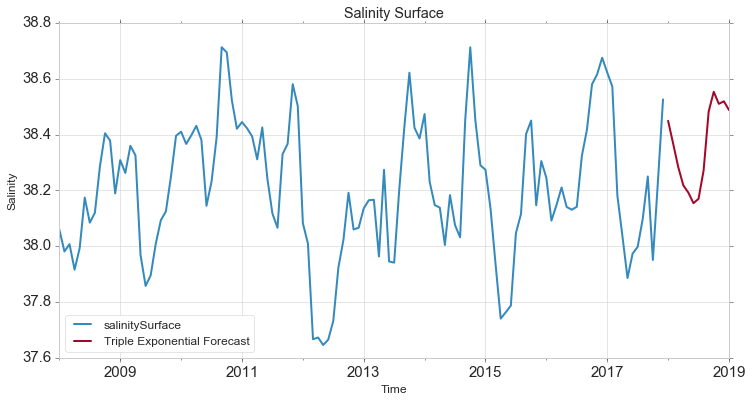

In [11]:
model = ExponentialSmoothing(dataSal['salinitySurface'],trend='add',seasonal='add',seasonal_periods=12)
results = model.fit()
fcast = results.predict(len(dataSal),len(dataSal)+12).rename('Triple Exponential Forecast')

# Plot predictions against known values
title = 'Salinity Surface'
ylabel='Salinity'
xlabel='Time'

ax = dataSal['salinitySurface'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Stationarity
Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.
A stationary time series is one whose properties do not depend on the time at which the series is observed. 

#### Differencing
Non-stationary data can be made to look stationary through differencing. A simple differencing method calculates the difference between consecutive points.

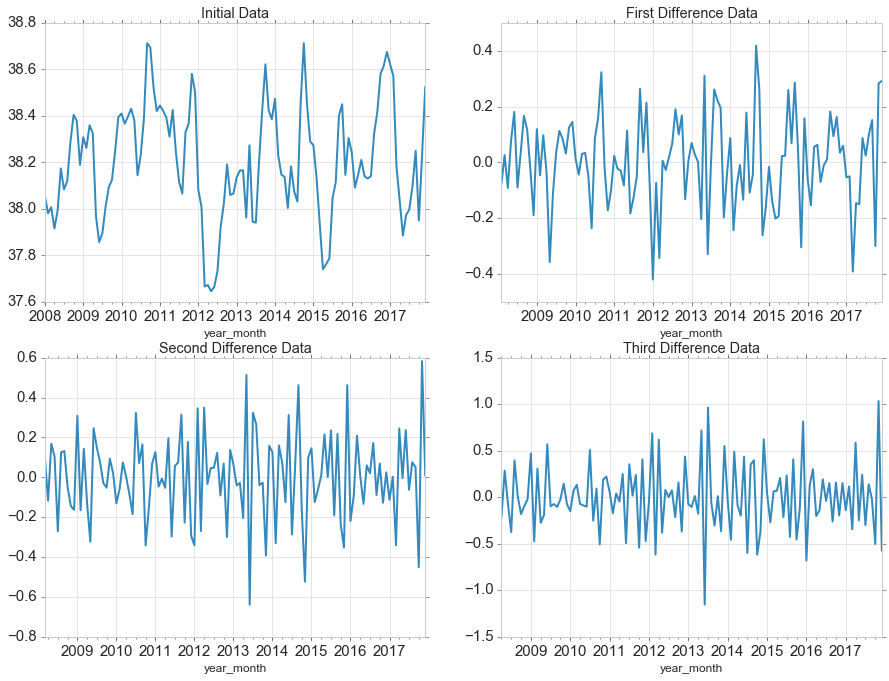

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 11))

dataSal['salinitySurfaceDiff1'] = diff(dataSal['salinitySurface'],k_diff=1)
dataSal['salinitySurfaceDiff2'] = diff(dataSal['salinitySurface'],k_diff=2)
dataSal['salinitySurfaceDiff3'] = diff(dataSal['salinitySurface'],k_diff=3)

dataSal['salinitySurface'].plot(title="Initial Data",ax=ax[0][0]).autoscale(axis='x',tight=True);
dataSal['salinitySurfaceDiff1'].plot(title="First Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
dataSal['salinitySurfaceDiff2'].plot(title="Second Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
dataSal['salinitySurfaceDiff3'].plot(title="Third Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);

NameError: name 'dataTemp' is not defined

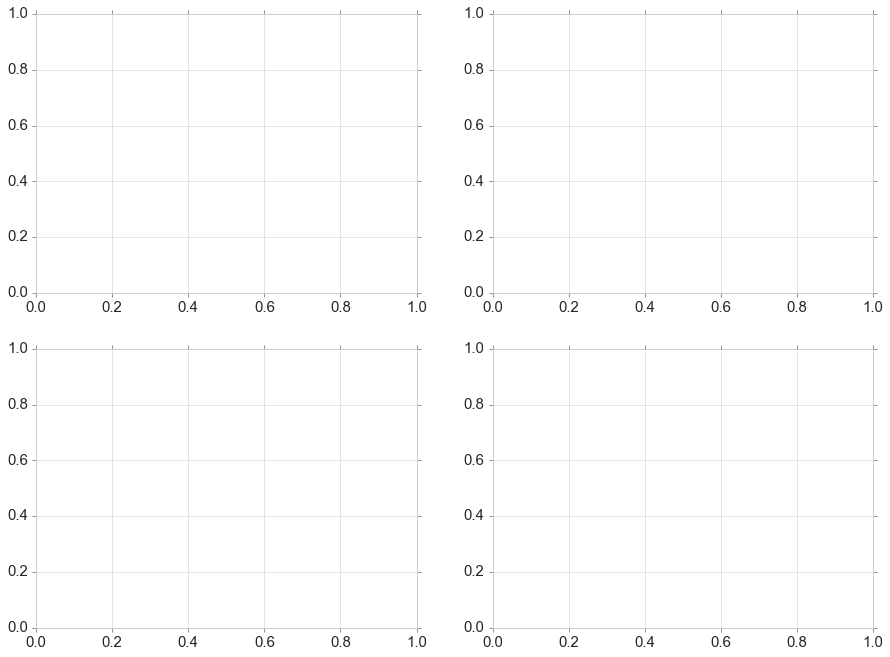

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 11))

dataTemp['temperatureSurfaceDiff1'] = diff(dataTemp['temperatureSurface'],k_diff=1)
dataTemp['temperatureSurfaceDiff2'] = diff(dataTemp['temperatureSurface'],k_diff=2)
dataTemp['temperatureSurfaceDiff3'] = diff(dataTemp['temperatureSurface'],k_diff=3)

dataTemp['temperatureSurface'].plot(title="Initial Data",ax=ax[0][0]).autoscale(axis='x',tight=True);
dataTemp['temperatureSurfaceDiff1'].plot(title="First Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
dataTemp['temperatureSurfaceDiff2'].plot(title="Second Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
dataTemp['temperatureSurfaceDiff3'].plot(title="Third Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);

## ARIMA
An ARIMA model is characterized by 3 components: p, d, q
-	p is the order of the AR term. It refers to the number of lags of Y to be used as predictors.
-	q is the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
-	d is the number of differencing required to make the time series stationary


### Check if Stationary

In [14]:
from statsmodels.tsa.stattools import adfuller
# check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [15]:
adf_test(dataSal['salinitySurface'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.525099
p-value                   0.000177
# lags used               1.000000
# observations          118.000000
critical value (1%)      -3.487022
critical value (5%)      -2.886363
critical value (10%)     -2.580009
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Automatically select ARIMA parameters

### Let's ignore the seasonality (for the sake of the example)

In [16]:
stepwise_fit = auto_arima(dataSal['salinitySurface'], start_p=0, start_q=0,
                          max_p=6, max_q=3,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
stepwise_fit.summary() 

Fit ARIMA: order=(0, 0, 0); AIC=2.873, BIC=8.448, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-104.209, BIC=-95.846, Fit time=0.058 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-76.533, BIC=-68.171, Fit time=0.053 seconds
Fit ARIMA: order=(2, 0, 0); AIC=-109.133, BIC=-97.983, Fit time=0.045 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-109.835, BIC=-95.897, Fit time=0.089 seconds
Fit ARIMA: order=(3, 0, 2); AIC=-107.789, BIC=-88.277, Fit time=0.412 seconds
Fit ARIMA: order=(1, 0, 1); AIC=-107.963, BIC=-96.813, Fit time=0.054 seconds
Fit ARIMA: order=(3, 0, 1); AIC=-107.835, BIC=-91.110, Fit time=0.141 seconds
Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.883 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 1)   Log Likelihood                  59.917
Method:                       css-mle   S.D. of innovations              0.146
Date:                Thu, 09 Apr 2020   AIC                           -109.835
Time:                        12:44:14   BIC                            -95.897
Sample:                             0   HQIC                          -104.175
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.2105      0.037   1033.724      0.000      38.138      38.283
ar.L1.y        1.4680      0.167      8.782      0.000       1.140       1.796
ar.L2.y       -0.6314      0.127     -4.978      0.000      -0.880      -0.383
ma.L1.y       -0.5476      0.191     -2.867      0.005      -0.922      -0.173
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1625           -0.4820j            1.2585           -0.0626
AR.2            1.1625           +0.4820j            1.2585            0.0626
MA.1            1.8261           +0.0000j            1.8261            0.0000
-----------------------------------------------------------------------------
"""

So we will choose an ARMA model with p(number of lags)=2 and q(size of moving window)=1
#### ARMA

In [ ]:
train = dataSal.iloc[:96]
test = dataSal.iloc[96:]

In [ ]:
model = ARMA(train['salinitySurface'],order=(2,1))
results = model.fit()
results.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,1) Predictions')

title = 'Surface Salinity'
ylabel='Salinity'
xlabel='' # we don't really need a label here

ax = test['salinitySurface'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Since it is an ARMA model, there is no seasonality in the predictions. For the sake of the example we chose not to search for seasonality components.

In [ ]:
test['salinitySurface'].mean()

In [ ]:
predictions.mean()

The model did not predict the noise, but has vary close mean to the unseen test set.

## SARIMA
It is an extension of ARIMA that accepts additional set of parameters that specifically describe the seasonal components of the model.

In [19]:
stepwise_fit = auto_arima(dataSal['salinitySurface'], start_p=0, start_q=0,
                          max_p=6, max_q=3,
                          seasonal=True, m=12,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                         )
stepwise_fit.summary()

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=33.924, BIC=45.074, Fit time=0.690 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=2.873, BIC=8.448, Fit time=0.030 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-104.203, BIC=-95.841, Fit time=0.100 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-107.506, BIC=-96.356, Fit time=0.146 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  57.753
Date:                Thu, 09 Apr 2020   AIC                           -107.506
Time:                        13:25:36   BIC                            -96.356
Sample:                             0   HQIC                          -102.978
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.2328      3.300      3.101      0.002       3.764      16.701
ar.L1          0.7322      0.086      8.477      0.000       0.563       0.901
ma.L1          0.2286      0.101      2.267      0.023       0.031       0.426
sigma2         0.0221      0.003      7.755      0.000       0.017       0.028
===================================================================================
Ljung-Box (Q):                       79.63   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.00   Prob(JB):                         0.75
Heteroskedasticity (H):               2.10   Skew:                            -0.15
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = dataSal.iloc[:96]
test = dataSal.iloc[96:]

In [22]:
model = SARIMAX(train['salinitySurface'],order=(1,0,0),seasonal_order=(0,1,2,12),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                    salinitySurface   No. Observations:                   96
Model:             SARIMAX(1, 0, 0)x(0, 1, 2, 12)   Log Likelihood               -1263.912
Date:                            Thu, 09 Apr 2020   AIC                           2535.824
Time:                                    13:26:01   BIC                           2545.547
Sample:                                01-01-2008   HQIC                          2539.733
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7715   8.44e-23   9.14e+21      0.000       0.771       0.771
ma.S.L12    4.738e+13         -0       -inf      0.000    4.74e+13    4.74e+13
ma.S.L24    -2.97e+14   1.32e-33  -2.25e+47      0.000   -2.97e+14   -2.97e+14
sigma2      2.116e-17   2.07e-10   1.02e-07      1.000   -4.06e-10    4.06e-10
===================================================================================
Ljung-Box (Q):                        5.02   Jarque-Bera (JB):             17930.91
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -8.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        72.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMA Predictions')

title = 'Surface Temperature'
ylabel='Temperature'
xlabel='' # we don't really need a label here

ax = test['temperatureSurface'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

error1 = mean_squared_error(test['temperatureSurface'], predictions)
error2 = rmse(test['temperatureSurface'], predictions)
print('SARIMA MSE Error: {}'.format(error))
print('SARIMA RMSE Error: {}'.format(error2))

Wow!

### Retrain the model on the full data, and forecast the future

In [ ]:
model = SARIMAX(dataTemp['temperatureSurface'],order=(1,0,0),seasonal_order=(0,1,1,12))
results = model.fit()
fcast = results.predict(len(dataTemp),len(dataTemp)+11,typ='levels').rename('SARIMA Forecast')

# Plot predictions against known values
title = 'Temperature Surface'
ylabel='Temperature'
xlabel=''

ax = dataTemp['temperatureSurface'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### VAR Model

In [ ]:
dataSal['temperatureSurface'] = dataTemp['temperatureSurface']
data = dataSal.copy()
data = data.drop(['salinitySurfaceDiff1','salinitySurfaceDiff2','salinitySurfaceDiff3'],axis=1)
data.head()

In [ ]:
ax = data['temperatureSurface'].plot(figsize=(15,6),legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
data['salinitySurface'].plot(legend=True);

In [ ]:
adf_test(data['temperatureSurface'])

In [ ]:
adf_test(data['salinitySurface'])

If on series was not stationary we would have to take the forst order of difference to both series so they retain the same number of observations.

In [ ]:
# train/test split
nobs=24
train, test = data[0:-nobs], data[-nobs:]

In [ ]:
print(train.shape)
print(test.shape)

#### VAR p selection

In [ ]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    #print('BIC: ', results.bic)

We choose order of 8.

In [ ]:
results = model.fit(7)
results.summary()

In [ ]:
lag_order = results.k_ar
z = results.forecast(y=train.values[-lag_order:], steps=nobs)
z

In [ ]:
test

In [ ]:
idx = pd.date_range('1/1/2016', periods=nobs, freq='MS')
df_forecast = pd.DataFrame(z, index=idx, columns=['salinitySurfaceForecast','temperatureSurfaceForecast'])
df_forecast

#### If we had differenced columns than we have to invert the transformation

In [ ]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
#df_forecast['temperatureSurface1d'] = (data['temperatureSurface'].iloc[-nobs-1]-data['temperatureSurface'].iloc[-nobs-2]) + df_forecast['temperatureSurface2d'].cumsum()

# Now build the forecast values from the first difference set
#df_forecast['temperatureSurfaceForecast'] = data['temperatureSurface'].iloc[-nobs-1] + df_forecast['temperatureSurface1d'].cumsum()

In [ ]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
#df_forecast['salinitySurface1d'] = (data['salinitySurface'].iloc[-nobs-1]-data['salinitySurface'].iloc[-nobs-2]) + df_forecast['salinitySurface2d'].cumsum()

# Now build the forecast values from the first difference set
#df_forecast['salinitySurfaceForecast'] = data['salinitySurface'].iloc[-nobs-1] + df_forecast['salinitySurface1d'].cumsum()

In [ ]:
df_forecast

In [ ]:
data['temperatureSurface'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['temperatureSurfaceForecast'].plot(legend=True);

In [ ]:
data['salinitySurface'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['salinitySurfaceForecast'].plot(legend=True);

In [ ]:
from sklearn.metrics import mean_squared_error

error1 = mean_squared_error(test['temperatureSurface'], df_forecast['temperatureSurfaceForecast'])
error2 = rmse(test['temperatureSurface'], predictions)
print('VAR Temperature MSE Error: {}'.format(error1))
print('VAR RMSE Error: {}'.format(error2))

In [ ]:
from sklearn.metrics import mean_squared_error

error1 = mean_squared_error(test['salinitySurface'], df_forecast['salinitySurfaceForecast'])
error2 = rmse(test['salinitySurface'], predictions)

print('VAR Salinity MSE Error: {}'.format(error1))
print('VAR RMSE Error: {}'.format(error2))

### VARMA Model

In [ ]:
data.head()

In [ ]:
auto_arima(data['salinitySurface'],maxiter=1000)

In [ ]:
auto_arima(data['temperatureSurface'],maxiter=1000)

In [ ]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    for j in [1,2,3,4,5,6,7,8,9,10]:
        model = VARMAX(train, order=(i,j), trend='c')
        results = model.fit()
        print('Order =', i,j)
        print('AIC: ', results.aic)
        #print('BIC: ', results.bic)

In [ ]:
model = VARMAX(train, order=(2,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

In [ ]:
df_forecast = results.forecast(24)
df_forecast

In [ ]:
data['temperatureSurface'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['temperatureSurface'].plot(legend=True);

In [ ]:
data['salinitySurface'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['salinitySurface'].plot(legend=True);

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['temperatureSurface'], df_forecast['temperatureSurface'])
print('VAR Temperature MSE Error: {}'.format(error))

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['salinitySurface'], df_forecast['salinitySurface'])
print('VAR Salinity MSE Error: {}'.format(error))